# E-Scooter Business Case Summary

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Revenue

In [ ]:
trips = pd.read_parquet('../matching/matching_candidates_scored.parquet')
trips = trips[~trips['vehicle_type_id'].str.contains('bic|bike', case=False, na=False)]
trips = trips[~trips['provider'].isin(['yoio_freiburg', 'hopp_konstanz', 'dott_bregenz'])]
trips_sorted = trips.sort_values('prob_forward', ascending=False)
best_matches = trips_sorted.groupby('d_idx').first().reset_index()
best_matches['week'] = pd.to_datetime(best_matches['d_time']).dt.isocalendar().week

from provider_specs import final_revenue
pricing_df = pd.DataFrame(final_revenue)

def get_provider_base(provider):
    if provider.startswith('voi_'):
        return provider
    return provider.split('_')[0]

best_matches['provider_base'] = best_matches['provider'].apply(get_provider_base)

avg_pricing = pricing_df.groupby('provider').agg(
    unlock_fee=('unlock_fee', 'mean'),
    price_per_min=('price_per_ride_pm', 'mean')
).reset_index()

best_matches = best_matches.merge(
    avg_pricing, 
    left_on='provider_base', 
    right_on='provider', 
    how='left',
    suffixes=('', '_pricing')
)

best_matches['revenue_gross'] = best_matches['unlock_fee'] + (best_matches['opt_route_min'] * best_matches['price_per_min'])

VAT_DE = 0.19
VAT_CH = 0.081

SWISS_PROVIDERS = ['bolt_zurich', 'bolt_basel', 'dott_zurich', 'dott_basel',
                   'dott_winterthur', 'dott_st_gallen', 'voi_ch',
                   'lime_zurich', 'lime_basel', 'lime_opfikon', 'lime_uster']

best_matches['is_swiss'] = best_matches['provider'].isin(SWISS_PROVIDERS)
best_matches['vat_rate'] = best_matches['is_swiss'].map({True: VAT_CH, False: VAT_DE})
best_matches['revenue'] = best_matches['revenue_gross'] / (1 + best_matches['vat_rate'])

weekly_revenue = best_matches.groupby('week').agg(
    n_trips=('d_idx', 'count'),
    total_revenue_gross=('revenue_gross', 'sum'),
    total_revenue=('revenue', 'sum')
).round(2)

print(f"Total trips: {weekly_revenue['n_trips'].sum():,}")
print(f"Total gross revenue (incl. VAT): EUR {weekly_revenue['total_revenue_gross'].sum():,.2f}")
print(f"Total net revenue (excl. VAT): EUR {weekly_revenue['total_revenue'].sum():,.2f}")

## 2. Energy Costs

In [ ]:
df = pd.read_parquet('../vehicle_events_export.parquet')
df = df.sort_values(['vehicle_id', 'timestamp']).reset_index(drop=True)
df = df[~df['vehicle_type_id'].str.contains('bic|bike', case=False, na=False)]

df['prev_range'] = df.groupby('vehicle_id')['current_range_meters'].shift(1)
df['range_change'] = df['current_range_meters'] - df['prev_range']
df['week'] = pd.to_datetime(df['timestamp']).dt.isocalendar().week

E_USABLE_WH = 297
MAX_RANGE_KM = 35
ETA_CHG = 0.85
WH_PER_KM = E_USABLE_WH / MAX_RANGE_KM

P_ELEC_DE = 0.0003
P_ELEC_CH = 0.00045

best_matches['electricity_wh'] = best_matches['range_consumed'] * WH_PER_KM
best_matches['electricity_grid_wh'] = best_matches['electricity_wh'] / ETA_CHG
best_matches['is_swiss'] = best_matches['provider'].isin(SWISS_PROVIDERS)
best_matches['p_elec'] = best_matches['is_swiss'].map({True: P_ELEC_CH, False: P_ELEC_DE})
best_matches['electricity_cost'] = best_matches['electricity_grid_wh'] * best_matches['p_elec']

weekly_active_elec = best_matches.groupby('week').agg(
    active_electricity_cost=('electricity_cost', 'sum')
).round(2)

HEAVY_DROP_THRESHOLD = -1000
passive_events = df[(df['range_change'] < 0) & (df['range_change'] >= HEAVY_DROP_THRESHOLD)].copy()
passive_events['drain_km'] = -passive_events['range_change'] / 1000
passive_events['electricity_wh'] = passive_events['drain_km'] * WH_PER_KM
passive_events['electricity_grid_wh'] = passive_events['electricity_wh'] / ETA_CHG
passive_events['is_swiss'] = passive_events['provider'].isin(SWISS_PROVIDERS)
passive_events['p_elec'] = passive_events['is_swiss'].map({True: P_ELEC_CH, False: P_ELEC_DE})
passive_events['electricity_cost'] = passive_events['electricity_grid_wh'] * passive_events['p_elec']

weekly_passive_elec = passive_events.groupby('week').agg(
    passive_electricity_cost=('electricity_cost', 'sum')
).round(2)

weekly_energy = weekly_active_elec.join(weekly_passive_elec, how='outer').fillna(0)
weekly_energy['total_electricity_cost'] = weekly_energy['active_electricity_cost'] + weekly_energy['passive_electricity_cost']

print(f"Total electricity cost: EUR {weekly_energy['total_electricity_cost'].sum():,.2f}")

## 3. Labor Costs

In [ ]:
R_LAB_DE = 14
R_LAB_CH = 26
T_SWAP = 1/6
T_REPAIR = 0.5
REPAIRS_PER_VEHICLE_PER_WEEK = 0.2

max_range_by_type = df.groupby('vehicle_type_id', observed=True)['current_range_meters'].max()
max_range_by_type = (max_range_by_type / 5000).round() * 5000 / 1000
df['max_range_km'] = df['vehicle_type_id'].map(max_range_by_type)

recharges = df[df['range_change'] > 10000].copy()
recharges['recharge_km'] = recharges['range_change'] / 1000
recharges['recharge_pct'] = recharges['recharge_km'] / recharges['max_range_km']
median_recharge_pct = recharges['recharge_pct'].median()

best_matches['max_range_km'] = best_matches['vehicle_type_id'].map(max_range_by_type)
best_matches['drain_pct'] = best_matches['range_consumed'] / best_matches['max_range_km']
best_matches['swaps'] = best_matches['drain_pct'] / median_recharge_pct
best_matches['r_lab'] = best_matches['is_swiss'].map({True: R_LAB_CH, False: R_LAB_DE})
best_matches['swap_cost'] = best_matches['swaps'] * best_matches['r_lab'] * T_SWAP

passive_events['max_range_km'] = passive_events['vehicle_type_id'].map(max_range_by_type)
passive_events['drain_pct'] = passive_events['drain_km'] / passive_events['max_range_km']
passive_events['swaps'] = passive_events['drain_pct'] / median_recharge_pct
passive_events['r_lab'] = passive_events['is_swiss'].map({True: R_LAB_CH, False: R_LAB_DE})
passive_events['swap_cost'] = passive_events['swaps'] * passive_events['r_lab'] * T_SWAP

weekly_active_labor = best_matches.groupby('week').agg(
    active_drain_pct=('drain_pct', 'sum'),
    active_swap_cost=('swap_cost', 'sum')
)
weekly_passive_labor = passive_events.groupby('week', observed=True).agg(
    passive_drain_pct=('drain_pct', 'sum'),
    passive_swap_cost=('swap_cost', 'sum')
)

weekly_labor = weekly_active_labor.join(weekly_passive_labor, how='outer').fillna(0)
weekly_labor['total_drain_pct'] = weekly_labor['active_drain_pct'] + weekly_labor['passive_drain_pct']
weekly_labor['n_swaps'] = weekly_labor['total_drain_pct'] / median_recharge_pct
weekly_labor['swap_cost'] = weekly_labor['active_swap_cost'] + weekly_labor['passive_swap_cost']

from geo_utils import estimate_fleet_size_per_provider
provider_stats = estimate_fleet_size_per_provider(df, window_minutes=10)
provider_fleet_size = provider_stats['fleet_size']
provider_operation_weeks = provider_stats['operation_days'] / 7

provider_is_swiss = pd.Series({p: p in SWISS_PROVIDERS for p in provider_fleet_size.index})
provider_r_lab = provider_is_swiss.map({True: R_LAB_CH, False: R_LAB_DE})
provider_total_repairs = provider_fleet_size * REPAIRS_PER_VEHICLE_PER_WEEK * provider_operation_weeks
provider_total_repair_cost = provider_total_repairs * provider_r_lab * T_REPAIR

fleet_size = provider_fleet_size.sum()
fleet_de = provider_fleet_size[~provider_is_swiss].sum()
fleet_ch = provider_fleet_size[provider_is_swiss].sum()

n_weeks = df['week'].nunique()
total_repair_cost = provider_total_repair_cost.sum()
weekly_repair_cost = total_repair_cost / n_weeks

weekly_labor['repair_cost'] = weekly_repair_cost
weekly_labor['total_labor_cost'] = weekly_labor['swap_cost'] + weekly_labor['repair_cost']

print(f"Fleet size: {fleet_size:,} vehicles (DE: {fleet_de:,}, CH: {fleet_ch:,})")
print(f"Total labor cost: EUR {weekly_labor['total_labor_cost'].sum():,.2f}")

## 4. Vehicle Depreciation

In [ ]:
SCOOTER_COST = 800
LIFETIME_KM = 12000
LIFETIME_WEEKS = 205

DEPRECIATION_PER_KM = SCOOTER_COST / LIFETIME_KM
DEPRECIATION_PER_WEEK = SCOOTER_COST / LIFETIME_WEEKS

best_matches['depreciation_km'] = best_matches['range_consumed'] * DEPRECIATION_PER_KM

provider_time_depreciation = provider_fleet_size * DEPRECIATION_PER_WEEK * provider_operation_weeks
total_time_depreciation = provider_time_depreciation.sum()
weekly_time_depreciation = total_time_depreciation / n_weeks

weekly_km_depreciation = best_matches.groupby('week')['depreciation_km'].sum()

weekly_depreciation = pd.DataFrame({
    'total_km': best_matches.groupby('week')['range_consumed'].sum(),
    'depreciation_distance': weekly_km_depreciation,
    'depreciation_time': weekly_time_depreciation
})
weekly_depreciation['depreciation_cost'] = (weekly_depreciation['depreciation_distance'] + 
                                             weekly_depreciation['depreciation_time'])

print(f"Total depreciation cost: EUR {weekly_depreciation['depreciation_cost'].sum():,.2f}")

## 5. Profit Summary

In [ ]:
PASS_DISCOUNT_RATE = 0.25

summary = weekly_revenue[['n_trips', 'total_revenue_gross', 'total_revenue']].join(
    weekly_energy[['total_electricity_cost']], how='outer'
).join(
    weekly_labor[['total_labor_cost']], how='outer'
).join(
    weekly_depreciation[['depreciation_cost']], how='outer'
).fillna(0)

summary['effective_vat_rate'] = (summary['total_revenue_gross'] / summary['total_revenue']) - 1
summary['discounted_gross'] = summary['total_revenue_gross'] * (1 - PASS_DISCOUNT_RATE)
summary['vat_on_discounted'] = summary['discounted_gross'] - (summary['discounted_gross'] / (1 + summary['effective_vat_rate']))
summary['clear_revenue'] = summary['discounted_gross'] - summary['vat_on_discounted']

summary['total_cost'] = (summary['total_electricity_cost'] + 
                         summary['total_labor_cost'] + 
                         summary['depreciation_cost'])
summary['profit'] = summary['clear_revenue'] - summary['total_cost']
summary['profit_margin'] = (summary['profit'] / summary['clear_revenue'] * 100).round(1)

print(f"Clear Revenue:    EUR {summary['clear_revenue'].sum():>12,.2f}")
print(f"Total Cost:       EUR {summary['total_cost'].sum():>12,.2f}")
print(f"PROFIT:           EUR {summary['profit'].sum():>12,.2f}")
print(f"Profit Margin:    {(summary['profit'].sum() / summary['clear_revenue'].sum() * 100):>12.1f}%")

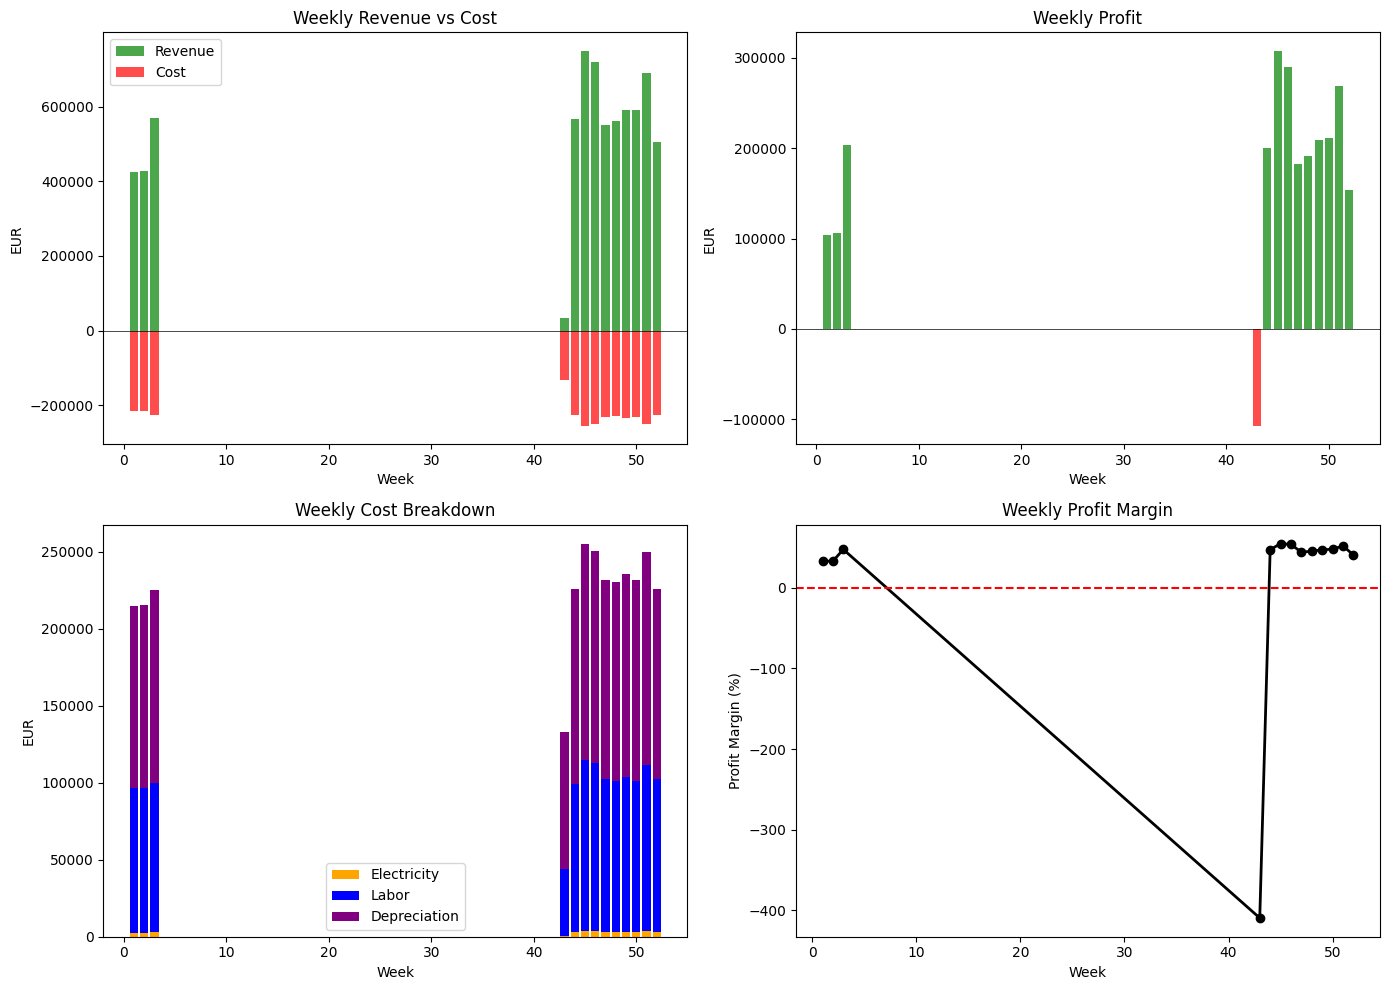

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

weeks = summary.index
axes[0, 0].bar(weeks, summary['total_revenue'], label='Revenue', color='green', alpha=0.7)
axes[0, 0].bar(weeks, -summary['total_cost'], label='Cost', color='red', alpha=0.7)
axes[0, 0].axhline(0, color='black', linewidth=0.5)
axes[0, 0].set_xlabel('Week')
axes[0, 0].set_ylabel('EUR')
axes[0, 0].set_title('Weekly Revenue vs Cost')
axes[0, 0].legend()

colors = ['green' if p > 0 else 'red' for p in summary['profit']]
axes[0, 1].bar(weeks, summary['profit'], color=colors, alpha=0.7)
axes[0, 1].axhline(0, color='black', linewidth=0.5)
axes[0, 1].set_xlabel('Week')
axes[0, 1].set_ylabel('EUR')
axes[0, 1].set_title('Weekly Profit')

axes[1, 0].bar(weeks, summary['total_electricity_cost'], label='Electricity', color='orange')
axes[1, 0].bar(weeks, summary['total_labor_cost'], bottom=summary['total_electricity_cost'], 
               label='Labor', color='blue')
axes[1, 0].bar(weeks, summary['depreciation_cost'], 
               bottom=summary['total_electricity_cost'] + summary['total_labor_cost'],
               label='Depreciation', color='purple')
axes[1, 0].set_xlabel('Week')
axes[1, 0].set_ylabel('EUR')
axes[1, 0].set_title('Weekly Cost Breakdown')
axes[1, 0].legend()

axes[1, 1].plot(weeks, summary['profit_margin'], 'ko-', linewidth=2)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Week')
axes[1, 1].set_ylabel('Profit Margin (%)')
axes[1, 1].set_title('Weekly Profit Margin')

plt.tight_layout()
plt.show()

## 6. Profit by Provider

In [ ]:
provider_revenue = best_matches.groupby('provider').agg(
    n_trips=('d_idx', 'count'),
    revenue=('revenue', 'sum'),
    total_km=('range_consumed', 'sum')
)

provider_active_elec = best_matches.groupby('provider')['electricity_cost'].sum()
provider_passive_elec = passive_events.groupby('provider')['electricity_cost'].sum()
provider_elec = provider_active_elec.add(provider_passive_elec, fill_value=0)

provider_active_swap = best_matches.groupby('provider')['swap_cost'].sum()
provider_passive_swap = passive_events.groupby('provider')['swap_cost'].sum()
provider_swap = provider_active_swap.add(provider_passive_swap, fill_value=0)

provider_labor = provider_swap.add(provider_total_repair_cost, fill_value=0)

provider_depreciation_km = best_matches.groupby('provider')['depreciation_km'].sum()

provider_summary = provider_revenue.copy()
provider_summary['fleet_size'] = provider_fleet_size
provider_summary['operation_days'] = provider_stats['operation_days']
provider_summary['electricity_cost'] = provider_elec
provider_summary['labor_cost'] = provider_labor
provider_summary['depreciation_km'] = provider_depreciation_km
provider_summary['depreciation_time'] = provider_time_depreciation
provider_summary['depreciation_cost'] = (provider_summary['depreciation_km'].fillna(0) + 
                                          provider_summary['depreciation_time'].fillna(0))
provider_summary['total_cost'] = (provider_summary['electricity_cost'] + 
                                   provider_summary['labor_cost'] + 
                                   provider_summary['depreciation_cost'])
provider_summary['profit'] = provider_summary['revenue'] - provider_summary['total_cost']
provider_summary['profit_margin'] = (provider_summary['profit'] / provider_summary['revenue'] * 100).round(1)
provider_summary['is_swiss'] = provider_summary.index.isin(SWISS_PROVIDERS)
provider_summary['trips_per_vehicle'] = (provider_summary['n_trips'] / provider_summary['fleet_size']).round(1)

provider_summary = provider_summary.sort_values('profit', ascending=False)

print(provider_summary[['n_trips', 'fleet_size', 'trips_per_vehicle', 'revenue', 'total_cost', 
                        'profit', 'profit_margin']].round(2))

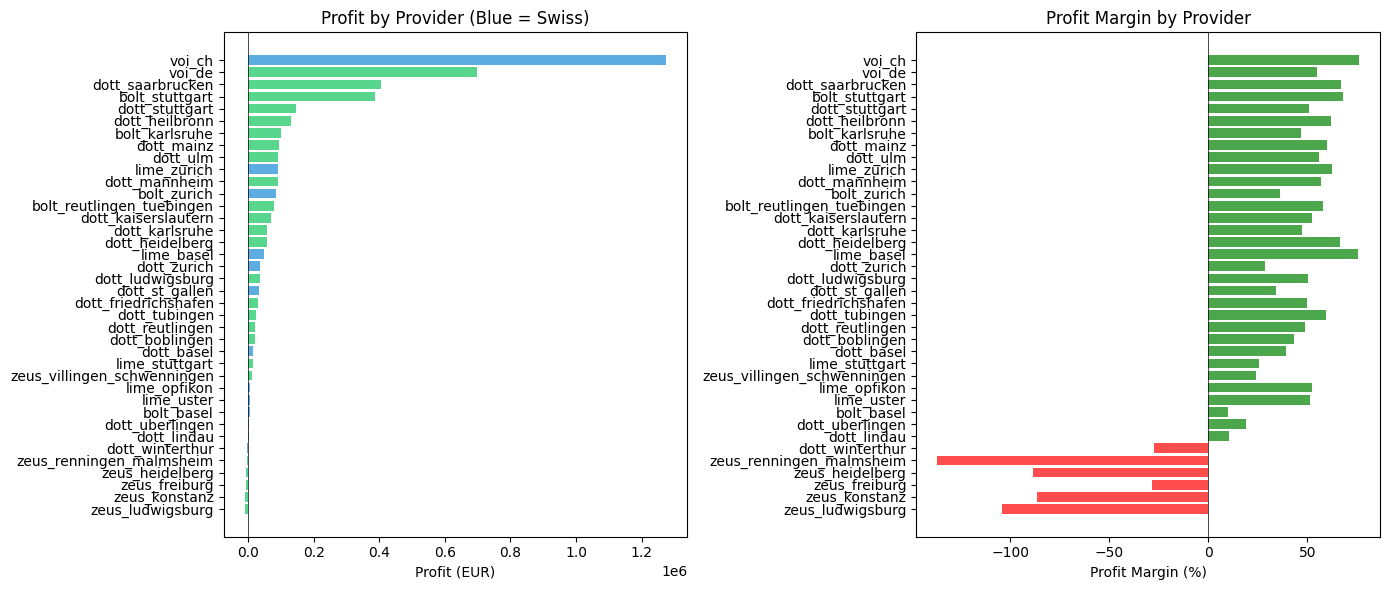

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#2ecc71' if not swiss else '#3498db' for swiss in provider_summary['is_swiss']]
axes[0].barh(provider_summary.index, provider_summary['profit'], color=colors, alpha=0.8)
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].set_xlabel('Profit (EUR)')
axes[0].set_title('Profit by Provider (Blue = Swiss)')
axes[0].invert_yaxis()

colors_margin = ['green' if m > 0 else 'red' for m in provider_summary['profit_margin']]
axes[1].barh(provider_summary.index, provider_summary['profit_margin'], color=colors_margin, alpha=0.7)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].set_xlabel('Profit Margin (%)')
axes[1].set_title('Profit Margin by Provider')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [10]:
summary.to_parquet('business_case_summary.parquet')
provider_summary.to_parquet('provider_summary.parquet')
print("Saved weekly summary to business_case_summary.parquet")
print("Saved provider summary to provider_summary.parquet")

Saved weekly summary to business_case_summary.parquet
Saved provider summary to provider_summary.parquet


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from tueplots import bundles
from tueplots.constants.color import rgb

PASS_DISCOUNT_RATE = 0.25

weeks_to_include = [45, 46, 47, 48, 49, 50, 51, 52, 1, 2]

summary_with_vat = weekly_revenue[['n_trips', 'total_revenue_gross', 'total_revenue']].join(
    weekly_energy[['total_electricity_cost']], how='outer'
).join(
    weekly_labor[['total_labor_cost']], how='outer'
).join(
    weekly_depreciation[['depreciation_cost']], how='outer'
).fillna(0)

summary_with_vat['vat_cost'] = summary_with_vat['total_revenue_gross'] - summary_with_vat['total_revenue']
summary_with_vat['total_cost'] = (summary_with_vat['total_electricity_cost'] + 
                                   summary_with_vat['total_labor_cost'] + 
                                   summary_with_vat['depreciation_cost'] +
                                   summary_with_vat['vat_cost'])
summary_with_vat['profit'] = summary_with_vat['total_revenue_gross'] - summary_with_vat['total_cost']

summary_with_vat['revenue_with_pass'] = summary_with_vat['total_revenue_gross'] * (1 - PASS_DISCOUNT_RATE)
summary_with_vat['vat_with_pass'] = summary_with_vat['revenue_with_pass'] - (summary_with_vat['revenue_with_pass'] / (1 + 0.19))
summary_with_vat['profit_with_pass'] = summary_with_vat['revenue_with_pass'] - (
    summary_with_vat['total_electricity_cost'] + 
    summary_with_vat['total_labor_cost'] + 
    summary_with_vat['depreciation_cost'] +
    summary_with_vat['vat_with_pass']
)

summary_plot = summary_with_vat.loc[weeks_to_include]

plt.rcParams.update(bundles.icml2024(column="full", nrows=1.1, ncols=2))

color_electricity = rgb.tue_gold
color_labor = rgb.tue_blue
color_depreciation = rgb.tue_violet
color_vat = rgb.tue_brown
color_profit = rgb.tue_green
color_loss = rgb.tue_red

fig, axes = plt.subplots(1, 2)

ax1 = axes[0]
weeks = weeks_to_include
x = np.arange(len(weeks))
width = 0.65

electricity = summary_plot['total_electricity_cost'].values
labor = summary_plot['total_labor_cost'].values
depreciation = summary_plot['depreciation_cost'].values
vat = summary_plot['vat_cost'].values
profit = summary_plot['profit'].values
profit_with_pass = summary_plot['profit_with_pass'].values

profit_certain = np.maximum(profit_with_pass, 0)
profit_uncertain = np.maximum(profit, 0) - profit_certain

ax1.bar(x, electricity, width, color=color_electricity, edgecolor='white', linewidth=0.5)
ax1.bar(x, labor, width, bottom=electricity, color=color_labor, edgecolor='white', linewidth=0.5)
ax1.bar(x, depreciation, width, bottom=electricity + labor, color=color_depreciation, edgecolor='white', linewidth=0.5)
ax1.bar(x, vat, width, bottom=electricity + labor + depreciation, color=color_vat, edgecolor='white', linewidth=0.5)
ax1.bar(x, profit_certain, width, bottom=electricity + labor + depreciation + vat, 
        color=color_profit, edgecolor='white', linewidth=0.5)
ax1.bar(x, profit_uncertain, width, bottom=electricity + labor + depreciation + vat + profit_certain,
        color=color_profit, edgecolor='white', linewidth=0.5, alpha=0.4, hatch='///')

week_labels = [f"W{w}'25" if w >= 45 else f"W{w}'26" for w in weeks]
ax1.set_xticks(x)
ax1.set_xticklabels(week_labels, rotation=45, ha='right')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'€{val/1e3:.0f}K'))
ax1.set_ylabel('Amount (EUR)')
ax1.set_xlabel('Week')
ax1.set_title('(a) Weekly Revenue Composition')
ax1.yaxis.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax1.set_axisbelow(True)

ax2 = axes[1]

def get_brand(provider):
    if provider.startswith('voi_'):
        return 'Voi'
    return provider.split('_')[0].title()

provider_data = provider_summary.copy()
provider_data['brand'] = provider_data.index.map(get_brand)

VAT_DE = 0.19
VAT_CH = 0.081
provider_data['vat_rate'] = provider_data['is_swiss'].map({True: VAT_CH, False: VAT_DE})
provider_data['revenue_gross'] = provider_data['revenue'] * (1 + provider_data['vat_rate'])
provider_data['vat_cost'] = provider_data['revenue_gross'] - provider_data['revenue']

brand_summary = provider_data.groupby('brand').agg({
    'revenue': 'sum',
    'revenue_gross': 'sum',
    'vat_cost': 'sum',
    'electricity_cost': 'sum',
    'labor_cost': 'sum',
    'depreciation_cost': 'sum',
}).sort_values('revenue_gross', ascending=False)

brand_summary['profit'] = (brand_summary['revenue_gross'] - brand_summary['electricity_cost']
                           - brand_summary['labor_cost'] - brand_summary['depreciation_cost']
                           - brand_summary['vat_cost'])
brand_summary['profit_margin'] = (brand_summary['profit'] / brand_summary['revenue_gross'] * 100).round(1)
brand_summary['revenue_with_pass'] = brand_summary['revenue_gross'] * (1 - PASS_DISCOUNT_RATE)
brand_summary['vat_with_pass'] = brand_summary['revenue_with_pass'] - (brand_summary['revenue_with_pass'] / (1 + 0.19))
brand_summary['profit_with_pass'] = (brand_summary['revenue_with_pass'] - brand_summary['electricity_cost']
                                      - brand_summary['labor_cost'] - brand_summary['depreciation_cost']
                                      - brand_summary['vat_with_pass'])
brand_summary['profit_margin_with_pass'] = (brand_summary['profit_with_pass'] / brand_summary['revenue_with_pass'] * 100).round(1)

brands = brand_summary.index.tolist()
y_pos = np.arange(len(brands))
bar_height = 0.6

brand_electricity = brand_summary['electricity_cost'].values
brand_labor = brand_summary['labor_cost'].values
brand_depreciation = brand_summary['depreciation_cost'].values
brand_vat = brand_summary['vat_cost'].values
brand_profit = brand_summary['profit'].values
brand_profit_with_pass = brand_summary['profit_with_pass'].values

brand_profit_certain = np.zeros_like(brand_profit)
brand_profit_uncertain = np.zeros_like(brand_profit)
brand_loss_certain = np.zeros_like(brand_profit)
brand_loss_uncertain = np.zeros_like(brand_profit)

for i in range(len(brand_profit)):
    if brand_profit[i] >= 0:
        brand_profit_certain[i] = max(brand_profit_with_pass[i], 0)
        brand_profit_uncertain[i] = brand_profit[i] - brand_profit_certain[i]
        if brand_profit_with_pass[i] < 0:
            brand_loss_uncertain[i] = -brand_profit_with_pass[i]
    else:
        brand_loss_certain[i] = -brand_profit[i]
        brand_loss_uncertain[i] = -brand_profit_with_pass[i] - brand_loss_certain[i]

ax2.barh(y_pos, brand_electricity, height=bar_height, color=color_electricity, edgecolor='white', linewidth=0.5)
ax2.barh(y_pos, brand_labor, height=bar_height, left=brand_electricity, color=color_labor, edgecolor='white', linewidth=0.5)
ax2.barh(y_pos, brand_depreciation, height=bar_height, left=brand_electricity + brand_labor, color=color_depreciation, edgecolor='white', linewidth=0.5)
ax2.barh(y_pos, brand_vat, height=bar_height, left=brand_electricity + brand_labor + brand_depreciation, color=color_vat, edgecolor='white', linewidth=0.5)
ax2.barh(y_pos, brand_profit_certain, height=bar_height, 
         left=brand_electricity + brand_labor + brand_depreciation + brand_vat, color=color_profit, edgecolor='white', linewidth=0.5)
ax2.barh(y_pos, brand_profit_uncertain, height=bar_height, 
         left=brand_electricity + brand_labor + brand_depreciation + brand_vat + brand_profit_certain,
         color=color_profit, edgecolor='white', linewidth=0.5, alpha=0.4, hatch='///')

loss_left = brand_electricity + brand_labor + brand_depreciation + brand_vat + brand_profit_certain + brand_profit_uncertain
ax2.barh(y_pos, brand_loss_certain, height=bar_height, left=loss_left, color=color_loss, edgecolor='white', linewidth=0.5)
ax2.barh(y_pos, brand_loss_uncertain, height=bar_height, left=loss_left + brand_loss_certain,
         color=color_loss, edgecolor='white', linewidth=0.5, alpha=0.4, hatch='///')

ax2.set_yticks(y_pos)
ax2.set_yticklabels(brands)
ax2.invert_yaxis()
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'€{val/1e6:.1f}M' if val >= 1e6 else f'€{val/1e3:.0f}K'))
ax2.set_xlabel('Amount (EUR)')
ax2.set_title('(b) Revenue Composition by Brand')
ax2.xaxis.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax2.set_axisbelow(True)

max_bar_end = 0
for i, (brand, row) in enumerate(brand_summary.iterrows()):
    bar_end = row['electricity_cost'] + row['labor_cost'] + row['depreciation_cost'] + row['vat_cost']
    bar_end += row['profit'] if row['profit'] >= 0 else abs(row['profit_with_pass'])
    max_bar_end = max(max_bar_end, bar_end)

ax2.set_xlim(0, max_bar_end * 1.25)

for i, (brand, row) in enumerate(brand_summary.iterrows()):
    margin = row['profit_margin']
    margin_pass = row['profit_margin_with_pass']
    bar_end = row['electricity_cost'] + row['labor_cost'] + row['depreciation_cost'] + row['vat_cost']
    bar_end += row['profit'] if row['profit'] >= 0 else abs(row['profit_with_pass'])
    label = f"{margin:.0f}\\% ({margin_pass:.0f}\\%)"
    ax2.text(bar_end + max_bar_end * 0.02, i, label, va='center', fontsize=6, color='gray')

legend_handles = [
    mpatches.Patch(facecolor=color_electricity, edgecolor='white', label='Electricity'),
    mpatches.Patch(facecolor=color_labor, edgecolor='white', label='Labor'),
    mpatches.Patch(facecolor=color_depreciation, edgecolor='white', label='Depreciation'),
    mpatches.Patch(facecolor=color_vat, edgecolor='white', label='VAT'),
    mpatches.Patch(facecolor=color_profit, edgecolor='white', label='Profit (cons.)'),
    mpatches.Patch(facecolor=color_profit, edgecolor='white', alpha=0.4, hatch='///', label='Profit (pass)'),
    mpatches.Patch(facecolor=color_loss, edgecolor='white', label='Loss (opt.)'),
    mpatches.Patch(facecolor=color_loss, edgecolor='white', alpha=0.4, hatch='///', label='Loss (pass)'),
]

ax2.legend(handles=legend_handles, loc='lower right', ncol=2, fontsize=5, 
           frameon=False, fancybox=False, edgecolor='black', facecolor='white')

plt.tight_layout()
plt.savefig('business_case_weekly_brand.pdf', bbox_inches='tight')
plt.savefig('business_case_weekly_brand.png', bbox_inches='tight', dpi=300)
plt.show()

## 7. Sensitivity Analysis

The profit estimates above rely on several uncertain assumptions. This tornado diagram shows how the profit margin changes when we vary each key parameter across a plausible range, holding all others at baseline. This reveals which assumptions drive the conclusion and whether profitability is robust to uncertainty.

In [ ]:
from tueplots import bundles
from tueplots.constants.color import rgb

BASELINE_CLEAR_REVENUE = summary['clear_revenue'].sum()
BASELINE_ELECTRICITY = summary['total_electricity_cost'].sum()
BASELINE_LABOR = summary['total_labor_cost'].sum()
BASELINE_DEPRECIATION = summary['depreciation_cost'].sum()
BASELINE_TOTAL_COST = summary['total_cost'].sum()
BASELINE_PROFIT = summary['profit'].sum()
BASELINE_MARGIN = (BASELINE_PROFIT / BASELINE_CLEAR_REVENUE) * 100

baseline = {
    'lifetime_km': 12000,
    'scooter_cost': 800,
    'labor_cost_factor': 1.0,
    'swap_time_min': 10,
    'repairs_per_week': 0.2,
    'pass_discount': 0.25,
    'electricity_price_factor': 1.0
}

ranges = {
    'lifetime_km': (8000, 16000),
    'scooter_cost': (600, 1000),
    'labor_cost_factor': (0.8, 1.2),
    'swap_time_min': (5, 15),
    'repairs_per_week': (0.1, 0.3),
    'pass_discount': (0.15, 0.35),
    'electricity_price_factor': (0.8, 1.3)
}

labels = {
    'lifetime_km': 'Vehicle Lifetime\n(base: 12,000 km)',
    'scooter_cost': 'Scooter Cost\n(base: €800)',
    'labor_cost_factor': 'Labor Cost\n(base: €14/h DE, €26/h CH)',
    'swap_time_min': 'Swap Time\n(base: 10 min)',
    'repairs_per_week': 'Repairs per Vehicle\n(base: 0.2/week)',
    'pass_discount': 'Pass Discount\n(base: 25\\%)',
    'electricity_price_factor': 'Electricity Price\n(base: €0.38/kWh avg)'
}

def format_value(param, value):
    if param == 'lifetime_km':
        return f'{value/1000:.0f}k km'
    elif param == 'scooter_cost':
        return f'€{value:.0f}'
    elif param == 'labor_cost_factor':
        return f'×{value:.1f}'
    elif param == 'swap_time_min':
        return f'{value:.0f} min'
    elif param == 'repairs_per_week':
        return f'{value:.1f}/wk'
    elif param == 'pass_discount':
        return f'{value*100:.0f}\\%'
    elif param == 'electricity_price_factor':
        return f'€{value * 0.375:.2f}/kWh'
    elif param == 'confidence_threshold':
        return value
    return str(value)

GROSS_REVENUE = summary['total_revenue_gross'].sum()
NET_REVENUE = summary['total_revenue'].sum()
EFFECTIVE_VAT_RATE = (GROSS_REVENUE / NET_REVENUE) - 1

BASELINE_DEPRECIATION_DISTANCE = weekly_depreciation['depreciation_distance'].sum()
BASELINE_DEPRECIATION_TIME = weekly_depreciation['depreciation_time'].sum()
BASELINE_SWAP_COST = weekly_labor['swap_cost'].sum()
BASELINE_REPAIR_COST = total_repair_cost

def calculate_margin_with_params(params):
    discounted_gross = GROSS_REVENUE * (1 - params['pass_discount'])
    clear_revenue = discounted_gross / (1 + EFFECTIVE_VAT_RATE)
    
    electricity = BASELINE_ELECTRICITY * params['electricity_price_factor']
    
    swap_time_factor = params['swap_time_min'] / baseline['swap_time_min']
    swap_cost = BASELINE_SWAP_COST * swap_time_factor * params['labor_cost_factor']
    
    repair_freq_factor = params['repairs_per_week'] / baseline['repairs_per_week']
    repair_cost = BASELINE_REPAIR_COST * repair_freq_factor * params['labor_cost_factor']
    
    labor = swap_cost + repair_cost
    
    depreciation_factor = (params['scooter_cost'] / params['lifetime_km']) / (baseline['scooter_cost'] / baseline['lifetime_km'])
    depreciation = (BASELINE_DEPRECIATION_DISTANCE + BASELINE_DEPRECIATION_TIME) * depreciation_factor
    
    total_cost = electricity + labor + depreciation
    profit = clear_revenue - total_cost
    return (profit / clear_revenue) * 100 if clear_revenue > 0 else 0

results = []
for param, (low, high) in ranges.items():
    params_low = baseline.copy()
    params_low[param] = low
    margin_low = calculate_margin_with_params(params_low)
    
    params_high = baseline.copy()
    params_high[param] = high
    margin_high = calculate_margin_with_params(params_high)
    
    results.append({
        'param': param, 'label': labels[param],
        'low_value': low, 'high_value': high,
        'low_value_fmt': format_value(param, low),
        'high_value_fmt': format_value(param, high),
        'margin_low': margin_low, 'margin_high': margin_high,
        'swing': abs(margin_high - margin_low)
    })

filtered_70 = best_matches[best_matches['prob_forward'] >= 0.70]
revenue_ratio_70 = filtered_70['revenue_gross'].sum() / GROSS_REVENUE

discounted_gross_70 = filtered_70['revenue_gross'].sum() * (1 - baseline['pass_discount'])
clear_revenue_70 = discounted_gross_70 / (1 + EFFECTIVE_VAT_RATE)

variable_cost_ratio = len(filtered_70) / len(best_matches)
electricity_70 = BASELINE_ELECTRICITY * variable_cost_ratio
swap_cost_70 = BASELINE_SWAP_COST * variable_cost_ratio
depreciation_dist_70 = BASELINE_DEPRECIATION_DISTANCE * variable_cost_ratio

total_cost_70 = electricity_70 + swap_cost_70 + BASELINE_REPAIR_COST + depreciation_dist_70 + BASELINE_DEPRECIATION_TIME

profit_70 = clear_revenue_70 - total_cost_70
margin_70 = (profit_70 / clear_revenue_70) * 100 if clear_revenue_70 > 0 else 0

results.append({
    'param': 'confidence_threshold', 
    'label': 'Match Confidence\n(base: $\\geq$0\\%)',
    'low_value': 0.70, 'high_value': 0.0,
    'low_value_fmt': r'$\geq$70\%',
    'high_value_fmt': r'$\geq$0\%',
    'margin_low': margin_70, 'margin_high': BASELINE_MARGIN,
    'swing': abs(BASELINE_MARGIN - margin_70)
})

results_df = pd.DataFrame(results).sort_values('swing', ascending=True)

plt.rcParams.update(bundles.icml2024(column="full", nrows=1, ncols=2))

color_electricity = rgb.tue_gold
color_labor = rgb.tue_blue
color_depreciation = rgb.tue_violet
color_vat = rgb.tue_brown
color_profit = rgb.tue_green
color_loss = rgb.tue_red

fig, axes = plt.subplots(1, 2)

ax1 = axes[0]
weeks_to_include = [45, 46, 47, 48, 49, 50, 51, 52, 1, 2]
summary_plot = summary.loc[weeks_to_include].copy()

summary_plot['vat_on_discounted'] = summary_plot['discounted_gross'] - summary_plot['clear_revenue']
summary_plot['clear_revenue_no_pass'] = summary_plot['total_revenue_gross'] / (1 + summary_plot['effective_vat_rate'])
summary_plot['profit_no_pass'] = summary_plot['clear_revenue_no_pass'] - summary_plot['total_cost']

x = np.arange(len(weeks_to_include))
width = 0.65

electricity = summary_plot['total_electricity_cost'].values
labor = summary_plot['total_labor_cost'].values
depreciation = summary_plot['depreciation_cost'].values
vat = summary_plot['vat_on_discounted'].values
profit_with_pass = summary_plot['profit'].values
profit_no_pass = summary_plot['profit_no_pass'].values

profit_certain = np.maximum(profit_with_pass, 0)
profit_uncertain = np.maximum(profit_no_pass, 0) - profit_certain
profit_neg = np.minimum(profit_with_pass, 0)

ax1.bar(x, electricity, width, color=color_electricity, edgecolor='white', linewidth=0.5)
ax1.bar(x, labor, width, bottom=electricity, color=color_labor, edgecolor='white', linewidth=0.5)
ax1.bar(x, depreciation, width, bottom=electricity + labor, color=color_depreciation, edgecolor='white', linewidth=0.5)
ax1.bar(x, vat, width, bottom=electricity + labor + depreciation, color=color_vat, edgecolor='white', linewidth=0.5)
ax1.bar(x, profit_certain, width, bottom=electricity + labor + depreciation + vat,
        color=color_profit, edgecolor='white', linewidth=0.5)
ax1.bar(x, profit_uncertain, width, bottom=electricity + labor + depreciation + vat + profit_certain,
        color=color_profit, edgecolor='white', linewidth=0.5, alpha=0.4, hatch='///')
ax1.bar(x, profit_neg, width, bottom=electricity + labor + depreciation + vat,
        color=color_loss, edgecolor='white', linewidth=0.5)

week_labels = [f"W{w}'25" if w >= 45 else f"W{w}'26" for w in weeks_to_include]
ax1.set_xticks(x)
ax1.set_xticklabels(week_labels, rotation=45, ha='right')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'€{val/1e3:.0f}K'))
ax1.set_ylabel('Amount (EUR)')
ax1.yaxis.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax1.set_axisbelow(True)

max_bar_height = (electricity + labor + depreciation + vat + profit_certain + profit_uncertain).max()
ax1.set_ylim(0, max_bar_height * 1.2)

import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor=color_electricity, edgecolor='white', label='Electricity'),
    mpatches.Patch(facecolor=color_labor, edgecolor='white', label='Labor'),
    mpatches.Patch(facecolor=color_depreciation, edgecolor='white', label='Depreciation'),
    mpatches.Patch(facecolor=color_vat, edgecolor='white', label='VAT'),
    mpatches.Patch(facecolor=color_profit, edgecolor='white', label='Profit (w/ pass)'),
    mpatches.Patch(facecolor=color_profit, edgecolor='white', alpha=0.4, hatch='///', label='Profit (no pass)'),
]
ax1.legend(handles=legend_handles, loc='upper right', frameon=False, ncol=2, fontsize=5)

ax2 = axes[1]
y_pos = np.arange(len(results_df))
bar_height = 0.6
color_low = rgb.tue_red
color_high = rgb.tue_green

all_margins = []
for _, row in results_df.iterrows():
    all_margins.extend([row['margin_low'], row['margin_high']])
margin_min_all = min(all_margins)
margin_max_all = max(all_margins)

x_range = margin_max_all - margin_min_all
ax2.set_xlim(margin_min_all - x_range * 0.22, margin_max_all + x_range * 0.22)

for i, row in enumerate(results_df.itertuples()):
    margin_min = min(row.margin_low, row.margin_high)
    margin_max = max(row.margin_low, row.margin_high)
    
    ax2.barh(i, BASELINE_MARGIN - margin_min, height=bar_height, left=margin_min,
            color=color_low, alpha=0.7, edgecolor='white', linewidth=0.5)
    ax2.barh(i, margin_max - BASELINE_MARGIN, height=bar_height, left=BASELINE_MARGIN,
            color=color_high, alpha=0.7, edgecolor='white', linewidth=0.5)
    
    if row.margin_low < row.margin_high:
        ax2.text(margin_min - 0.5, i, row.low_value_fmt, va='center', ha='right', color='gray', fontsize=6)
        ax2.text(margin_max + 0.5, i, row.high_value_fmt, va='center', ha='left', color='gray', fontsize=6)
    else:
        ax2.text(margin_min - 0.5, i, row.high_value_fmt, va='center', ha='right', color='gray', fontsize=6)
        ax2.text(margin_max + 0.5, i, row.low_value_fmt, va='center', ha='left', color='gray', fontsize=6)

ax2.axvline(BASELINE_MARGIN, color='black', linestyle='-', linewidth=1.5, zorder=10)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(results_df['label'], fontsize=6)
ax2.set_xlabel('Profit Margin (\\%)')
ax2.xaxis.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax2.set_axisbelow(True)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linewidth=1.5, marker='|', markersize=10, linestyle='None',
           label=f'Baseline ({BASELINE_MARGIN:.1f}\\%)'),
    Patch(facecolor=color_high, alpha=0.7, label='Higher margin'),
    Patch(facecolor=color_low, alpha=0.7, label='Lower margin')
]
ax2.legend(handles=legend_elements, loc='lower left', frameon=False, fontsize=6)

plt.tight_layout()
plt.savefig('sensitivity_tornado.pdf', bbox_inches='tight')
plt.savefig('sensitivity_tornado.png', bbox_inches='tight', dpi=300)
plt.show()